In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

**Data cleaning**

In [35]:
data = pd.read_csv(r'C:\Investigation\wage phillips curve with labor market power\2_data\data.csv')
data = data.drop(columns = ['Unnamed: 0', 'regis', 'area', 'salar_dsct', 'pens', 'pens_car', 'arl'])
data = data[['period', 'mes', 'trimestre', 'oci', 'empi', 'dpto', 'ciiu', 'inglabo', 'fex', 'sex']]
data.head()

,period,mes,trimestre,oci,empi,dpto,ciiu,inglabo,fex,sex
0,200801,1,1,1,1.0,5,5211,433700,901.516052,1
1,200801,1,1,1,1.0,5,7499,550000,1078.451538,1
2,200801,1,1,1,1.0,5,5239,433700,1159.833008,1
3,200801,1,1,1,1.0,5,1551,770000,1036.540283,0
4,200801,1,1,1,1.0,5,7512,680000,1162.002563,0


In [36]:
data = data[data['dpto'] != 25] # We removed Cundinamarca because it doesn't have values for unemployment.
data['ocu'] = data['oci'] * data['fex']
data.sort_values(by=['period', 'dpto'])
data = data[['period', 'mes', 'trimestre', 'ocu', 'empi', 'dpto', 'ciiu', 'inglabo', 'fex', 'sex']]
data['period'] = pd.to_datetime(data['period'], format = '%Y%m')

data.head()

,period,mes,trimestre,ocu,empi,dpto,ciiu,inglabo,fex,sex
0,2008-01-01,1,1,901.516052,1.0,5,5211,433700,901.516052,1
1,2008-01-01,1,1,1078.451538,1.0,5,7499,550000,1078.451538,1
2,2008-01-01,1,1,1159.833008,1.0,5,5239,433700,1159.833008,1
3,2008-01-01,1,1,1036.540283,1.0,5,1551,770000,1036.540283,0
4,2008-01-01,1,1,1162.002563,1.0,5,7512,680000,1162.002563,0


In [37]:
unem = pd.read_excel(r"C:\Investigation\wage phillips curve with labor market power\2_data\unemployment rates.xlsx",
                     sheet_name = "Unemployment")
unem['period'] = pd.to_datetime(unem['period'], format='%Y%m')
data = pd.merge(data, unem, on = ['period', 'dpto'])

data.head()

,period,mes,trimestre,ocu,empi,dpto,ciiu,inglabo,fex,sex,unem
0,2008-01-01,1,1,901.516052,1.0,5,5211,433700,901.516052,1,0.093667
1,2008-01-01,1,1,1078.451538,1.0,5,7499,550000,1078.451538,1,0.093667
2,2008-01-01,1,1,1159.833008,1.0,5,5239,433700,1159.833008,1,0.093667
3,2008-01-01,1,1,1036.540283,1.0,5,1551,770000,1036.540283,0,0.093667
4,2008-01-01,1,1,1162.002563,1.0,5,7512,680000,1162.002563,0,0.093667


In [38]:
unique = data['empi'].value_counts()
print("Unique values ​​in column'oci':")
print(unique)

Unique values ​​in column'oci':
empi
0.0    2424109
1.0    1051911
Name: count, dtype: int64


**Labor Market**

In [39]:
data_labor = data

data_labor['total_ocu'] = data.groupby(['period', 'dpto', 'ciiu'])['ocu'].transform('sum')

data_labor['ocu_share'] = data_labor['ocu'] / data_labor['total_ocu']
data_labor['ocu_share2'] = data_labor['ocu_share']**2
data_labor['ihh'] = data_labor.groupby(['period', 'dpto', 'ciiu'])['ocu_share2'].transform('sum')

data_labor.head()

,period,mes,trimestre,ocu,empi,dpto,ciiu,inglabo,fex,sex,unem,total_ocu,ocu_share,ocu_share2,ihh
0,2008-01-01,1,1,901.516052,1.0,5,5211,433700,901.516052,1,0.093667,25703.299561,0.035074,0.001230,0.058873
1,2008-01-01,1,1,1078.451538,1.0,5,7499,550000,1078.451538,1,0.093667,17158.848877,0.062851,0.003950,0.089118
2,2008-01-01,1,1,1159.833008,1.0,5,5239,433700,1159.833008,1,0.093667,11239.832092,0.103190,0.010648,0.173485
3,2008-01-01,1,1,1036.540283,1.0,5,1551,770000,1036.540283,0,0.093667,17254.465698,0.060074,0.003609,0.092702
4,2008-01-01,1,1,1162.002563,1.0,5,7512,680000,1162.002563,0,0.093667,3946.805420,0.294416,0.086681,0.336138


In [40]:
data['period'] = data['period'].dt.strftime('%Y-%m')
data['period'] = pd.to_datetime(data['period'])

data3 = data.groupby(['period', 'dpto']).agg({'unem': 'mean', 'inglabo': 'median', 'ihh': 'mean',}).reset_index()

#data3.sort_values(by=['dpto', 'period'], inplace = True)

data3['dln_meansalary'] = np.log(data3['inglabo']) - np.log(data3['inglabo'].shift(1))

#data3['ln_salary'] = np.log(data3['inglabo'])
#data3.loc[data3['period'] == '2008-01-01', 'ln_salary'] = None
#data3.sort_values(by = ['dpto', 'period'])

#data3['dln_salary'] = data3.groupby('dpto')['ln_salary'].shift(1)

data3['dln_meansalary_dpto'] = np.log(data3['inglabo']) - np.log(data3.groupby('dpto')['inglabo'].shift(1))

hhi_median = data3['ihh'].median()
data3['high_mkp'] = ((data3['ihh'] > hhi_median) & (data3['ihh'].notna())).astype(int)
data3['low_mkp'] = (data3['ihh'] <= hhi_median).astype(int)

data3['inglabo'] = data3['inglabo'].map('{:.2f}'.format).astype(float)

data3.to_stata(r'C:\Investigation\wage phillips curve with labor market power\2_data\monthly_model_data_error.dta')
data3.to_csv(r'C:\Investigation\wage phillips curve with labor market power\2_data\monthly_model_data_error.csv')

data3.head()

,period,dpto,unem,inglabo,ihh,dln_meansalary,dln_meansalary_dpto,high_mkp,low_mkp
0,2008-01-01,5,0.093667,461500.0,0.238280,NaN,NaN,1,0
1,2008-01-01,8,0.096063,461500.0,0.268242,0.000000,NaN,1,0
2,2008-01-01,11,0.093667,570000.0,0.245502,0.211154,NaN,1,0
3,2008-01-01,13,0.115098,520000.0,0.331336,-0.091808,NaN,1,0
4,2008-01-01,15,0.119025,461500.0,0.297796,-0.119347,NaN,1,0


In [41]:
data_labor = data.groupby(['period', 'dpto']).agg({'unem': 'mean', 'inglabo': 'median', 'ihh': 'mean',}).reset_index() # Mean or median?

data_labor.sort_values(by=['dpto', 'period'], inplace = True)

data_labor['dln_meansalary'] = np.log(data_labor['inglabo']) - np.log(data_labor['inglabo'].shift(12))
data_labor['dln_meansalary_dpto'] = np.log(data_labor['inglabo']) - np.log(data_labor.groupby('dpto')['inglabo'].shift(12))

hhi_median = data_labor['ihh'].median()
data_labor['high_mkp'] = ((data_labor['ihh'] > hhi_median) & (data_labor['ihh'].notna())).astype(int)
data_labor['low_mkp'] = (data_labor['ihh'] <= hhi_median).astype(int)

data_labor['inglabo'] = data_labor['inglabo'].map('{:.2f}'.format).astype(float)

data_labor.to_stata(r'C:\Investigation\wage phillips curve with labor market power\2_data\monthly_model_data.dta')
data_labor.to_csv(r'C:\Investigation\wage phillips curve with labor market power\2_data\monthly_model_data.csv')

data_labor.head()

,period,dpto,unem,inglabo,ihh,dln_meansalary,dln_meansalary_dpto,high_mkp,low_mkp
0,2008-01-01,5,0.093667,461500.0,0.238280,NaN,NaN,1,0
23,2008-02-01,5,0.108436,480000.0,0.211341,NaN,NaN,1,0
46,2008-03-01,5,0.113767,480000.0,0.214937,NaN,NaN,1,0
69,2008-04-01,5,0.109162,500000.0,0.227790,NaN,NaN,1,0
92,2008-05-01,5,0.102130,520000.0,0.219899,NaN,NaN,1,0


**Formal Labor Market**

In [42]:
data_for = data[data['empi'] == 1]

data_for['total_ocu'] = data_for.groupby(['period', 'dpto', 'ciiu'])['ocu'].transform('sum')
data_for['ocu_share'] = data_for['ocu'] / data_for['total_ocu']
data_for['ocu_share2'] = data_for['ocu_share']**2
data_for['ihh'] = data_for.groupby(['period', 'dpto', 'ciiu'])['ocu_share2'].transform('sum')
data_for.head()

C:\Users\harol\AppData\Local\Temp\ipykernel_12508\3677609257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for['total_ocu'] = data_for.groupby(['period', 'dpto', 'ciiu'])['ocu'].transform('sum')
C:\Users\harol\AppData\Local\Temp\ipykernel_12508\3677609257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for['ocu_share'] = data_for['ocu'] / data_for['total_ocu']
C:\Users\harol\AppData\Local\Temp\ipykernel_12508\3677609257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy

,period,mes,trimestre,ocu,empi,dpto,ciiu,inglabo,fex,sex,unem,total_ocu,ocu_share,ocu_share2,ihh
0,2008-01-01,1,1,901.516052,1.0,5,5211,433700,901.516052,1,0.093667,12064.843689,0.074723,0.005583,0.082668
1,2008-01-01,1,1,1078.451538,1.0,5,7499,550000,1078.451538,1,0.093667,15229.871582,0.070812,0.005014,0.105045
2,2008-01-01,1,1,1159.833008,1.0,5,5239,433700,1159.833008,1,0.093667,7539.316467,0.153838,0.023666,0.144669
3,2008-01-01,1,1,1036.540283,1.0,5,1551,770000,1036.540283,0,0.093667,6803.596069,0.152352,0.023211,0.156233
4,2008-01-01,1,1,1162.002563,1.0,5,7512,680000,1162.002563,0,0.093667,3946.805420,0.294416,0.086681,0.336138


In [43]:
data_for = data_for.groupby(['period', 'dpto']).agg({'unem': 'mean', 'inglabo': 'median', 'ihh': 'mean',}).reset_index() # Mean or median?

data_for.sort_values(by=['dpto', 'period'], inplace = True)

data_for['dln_meansalary'] = np.log(data_for['inglabo']) - np.log(data_for['inglabo'].shift(12))
data_for['dln_meansalary_dpto'] = np.log(data_for['inglabo']) - np.log(data_for.groupby('dpto')['inglabo'].shift(12))

hhi_median = data_for['ihh'].median()
data_for['high_mkp'] = ((data_for['ihh'] > hhi_median) & (data_for['ihh'].notna())).astype(int)
data_for['low_mkp'] = (data_for['ihh'] <= hhi_median).astype(int)

data_for['inglabo'] = data_for['inglabo'].map('{:.2f}'.format).astype(float)

data_for.to_stata(r'C:\Investigation\wage phillips curve with labor market power\2_data\monthly_model_data_for.dta')
data_for.to_csv(r'C:\Investigation\wage phillips curve with labor market power\2_data\monthly_model_data_for.csv')

data_for.head()

,period,dpto,unem,inglabo,ihh,dln_meansalary,dln_meansalary_dpto,high_mkp,low_mkp
0,2008-01-01,5,0.093667,566000.0,0.284598,NaN,NaN,0,1
23,2008-02-01,5,0.108436,600000.0,0.249562,NaN,NaN,0,1
46,2008-03-01,5,0.113767,600000.0,0.283993,NaN,NaN,0,1
69,2008-04-01,5,0.109162,600000.0,0.274335,NaN,NaN,0,1
92,2008-05-01,5,0.102130,621500.0,0.264552,NaN,NaN,0,1


**Informal Labor Market**

In [44]:
data_inf = data[data['empi'] == 0]

data_inf['total_ocu'] = data_inf.groupby(['period', 'dpto', 'ciiu'])['ocu'].transform('sum')
data_inf['ocu_share'] = data_inf['ocu'] / data_inf['total_ocu']
data_inf['ocu_share2'] = data_inf['ocu_share']**2
data_inf['ihh'] = data_inf.groupby(['period', 'dpto', 'ciiu'])['ocu_share2'].transform('sum')
data_inf.head()

C:\Users\harol\AppData\Local\Temp\ipykernel_12508\2236028453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_inf['total_ocu'] = data_inf.groupby(['period', 'dpto', 'ciiu'])['ocu'].transform('sum')
C:\Users\harol\AppData\Local\Temp\ipykernel_12508\2236028453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_inf['ocu_share'] = data_inf['ocu'] / data_inf['total_ocu']
C:\Users\harol\AppData\Local\Temp\ipykernel_12508\2236028453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy

,period,mes,trimestre,ocu,empi,dpto,ciiu,inglabo,fex,sex,unem,total_ocu,ocu_share,ocu_share2,ihh
10,2008-01-01,1,1,923.348633,0.0,5,5139,600000,923.348633,0,0.093667,5109.017639,0.180729,0.032663,0.275954
13,2008-01-01,1,1,1426.841309,0.0,5,9500,80000,1426.841309,1,0.093667,50051.008789,0.028508,0.000813,0.031246
14,2008-01-01,1,1,1426.841309,0.0,5,4521,461500,1426.841309,0,0.093667,41376.589111,0.034484,0.001189,0.171457
15,2008-01-01,1,1,895.233704,0.0,5,9500,200000,895.233704,1,0.093667,50051.008789,0.017886,0.000320,0.031246
24,2008-01-01,1,1,1011.073303,0.0,5,5529,433700,1011.073303,0,0.093667,2753.444641,0.367203,0.134838,0.347115


In [45]:
data_inf = data_inf.groupby(['period', 'dpto']).agg({'unem': 'mean', 'inglabo': 'median', 'ihh': 'mean',}).reset_index() # Mean or median?

data_inf.sort_values(by=['dpto', 'period'], inplace = True)

data_inf['dln_meansalary'] = np.log(data_inf['inglabo']) - np.log(data_inf['inglabo'].shift(12))
data_inf['dln_meansalary_dpto'] = np.log(data_inf['inglabo']) - np.log(data_inf.groupby('dpto')['inglabo'].shift(12))

hhi_median = data_inf['ihh'].median()
data_inf['high_mkp'] = ((data_inf['ihh'] > hhi_median) & (data_inf['ihh'].notna())).astype(int)
data_inf['low_mkp'] = (data_inf['ihh'] <= hhi_median).astype(int)

data_inf['inglabo'] = data_inf['inglabo'].map('{:.2f}'.format).astype(float)

data_inf.to_stata(r'C:\Investigation\wage phillips curve with labor market power\2_data\monthly_model_data_inf.dta')
data_inf.to_csv(r'C:\Investigation\wage phillips curve with labor market power\2_data\monthly_model_data_inf.csv')

data_inf.head()

,period,dpto,unem,inglabo,ihh,dln_meansalary,dln_meansalary_dpto,high_mkp,low_mkp
0,2008-01-01,5,0.093667,400000.0,0.342463,NaN,NaN,1,0
23,2008-02-01,5,0.108436,360000.0,0.323074,NaN,NaN,1,0
46,2008-03-01,5,0.113767,430000.0,0.292394,NaN,NaN,1,0
69,2008-04-01,5,0.109162,422000.0,0.353844,NaN,NaN,1,0
92,2008-05-01,5,0.102130,450000.0,0.339472,NaN,NaN,1,0


**Geographic data**

In [46]:
gdf = gpd.read_file(r'C:\Investigation\wage phillips curve with labor market power\2_data\sources\Colombia_departamentos_poblacion.geojson')
gdf_for = gpd.read_file(r'C:\Investigation\wage phillips curve with labor market power\2_data\sources\Colombia_departamentos_poblacion.geojson')
gdf_inf = gpd.read_file(r'C:\Investigation\wage phillips curve with labor market power\2_data\sources\Colombia_departamentos_poblacion.geojson')

gdf.rename(columns={'DPTO_CCDGO': 'dpto'}, inplace=True)
gdf['dpto'] = gdf['dpto'].astype('int64')

gdf_for.rename(columns={'DPTO_CCDGO': 'dpto'}, inplace=True)
gdf_for['dpto'] = gdf_for['dpto'].astype('int64')

gdf_inf.rename(columns={'DPTO_CCDGO': 'dpto'}, inplace=True)
gdf_inf['dpto'] = gdf_inf['dpto'].astype('int64')

data_labor_map = data_labor.groupby(['dpto']).agg({'ihh': 'mean'}).reset_index()
data_for_map = data_for.groupby(['dpto']).agg({'ihh': 'mean'}).reset_index()
data_inf_map = data_inf.groupby(['dpto']).agg({'ihh': 'mean'}).reset_index()

gdf = pd.merge(gdf, data_labor_map, on='dpto', how='left')
gdf_for = pd.merge(gdf_for, data_for_map, on='dpto', how='left')
gdf_inf = pd.merge(gdf_inf, data_inf_map, on='dpto', how='left')

gdf['dpto'] = gdf['dpto'].astype('object')
gdf_for['dpto'] = gdf_for['dpto'].astype('object')
gdf_inf['dpto'] = gdf_inf['dpto'].astype('object')

gdf.to_file(r'C:\Investigation\wage phillips curve with labor market power\2_data\map.geojson', driver='GeoJSON')
gdf_for.to_file(r'C:\Investigation\wage phillips curve with labor market power\2_data\map_for.geojson', driver='GeoJSON')
gdf_inf.to_file(r'C:\Investigation\wage phillips curve with labor market power\2_data\map_inf.geojson', driver='GeoJSON')

**This is to review the data**

In [20]:
percentil_50 = data['ihh'].quantile(0.5)

print("El percentil 50 (mediana) del ihh es:", percentil_50)

El percentil 50 (mediana) del ihh es: 0.11898546987166142


In [18]:
check = data[(data['ciiu'] == 6412) & (data['dpto'] == 8) & (data['period'] == 200807)]
check.head(11)

,regis,period,date,mes,trimestre,ciiu2,ciiu,area,dpto,oci,...,arl,fex,empi,total_ocu,ocu_share,ocu_share2,ihh,unem,year,year_month


In [19]:
check['ocu'].sum()

0.0

In [20]:
#vacancy_share = data.groupby(['ciiu', 'dpto', 'period'])['ocu'].apply(lambda x: x.sum() / x.count()).reset_index(name='vacancy_share')
#data = pd.merge(data, vacancy_share, on=['ciiu', 'dpto', 'period'], how='left')
#data.head()

In [21]:
#data = data.groupby(['ciiu', 'dpto', 'period'])['ocu'].sum().reset_index()
#data['vac_share'] = data.apply(lambda row: row['ocu'] / data[(data['ciiu'] == row['ciiu']) & (data['dpto'] == row['dpto']) & (data['period'] == row['period'])]['ocu'].sum(), axis=1)
#data.head()

In [22]:
num_valores_unicos = data['lmp'].nunique()

# Obtener los valores únicos en la columna 'dpto'
valores_unicos = data['lmp'].unique()

conteo = data['lmp'].value_counts()

# Imprimir el número de valores únicos y los valores únicos
print("Número de valores únicos:", num_valores_unicos)
print("Valores únicos:", valores_unicos)
print("Cantidad de 1:", conteo[1])
print("Cantidad de 0:", conteo[0])

KeyError: 'lmp'

In [ ]:
data_200807 = data[data['period'] == 200807]

valores_unicos_ciiu_200807 = data_200807['ciiu'].nunique()

print("Number of unique values ​​of 'ciiu' for the period 200807:", valores_unicos_ciiu_200807)

conteo_ciiu_6412 = data_200807[data_200807['ciiu'] == 6412]['ciiu'].count()

print("The value 6412 appears", conteo_ciiu_6412, "times in the period 200807.")

Number of unique values ​​of 'ciiu' for the period 200807: 0
The value 6412 appears 0 times in the period 200807.


In [ ]:
data_filtrado1 = data[data['period'] == 200807]
data_filtrado1['ocu'].sum()

0.0

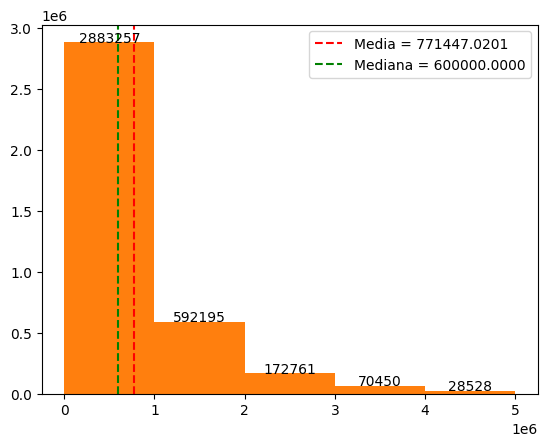

In [52]:
data_filtrado2 = data[data["inglabo"] < 5000000]
frec = data_filtrado2["inglabo"]

plt.hist(frec, bins=5)
frecuencias = plt.hist(frec, bins=5)[0]

for i, frecuencia in enumerate(frecuencias):
    plt.text(x=(plt.hist(frec, bins=5)[1][i] + plt.hist(frec, bins=5)[1][i+1]) / 2 - 0.5,
             y=frecuencia + 0.1,
             s=str(int(frecuencia)),
             size=10,
             ha='center')

media = np.mean(frec)
mediana = np.median(frec)

plt.axvline(media, color='r', linestyle='--', label=f'Media = {media:.4f}')
plt.axvline(mediana, color='g', linestyle='--', label=f'Mediana = {mediana:.4f}')

plt.legend()

plt.show()

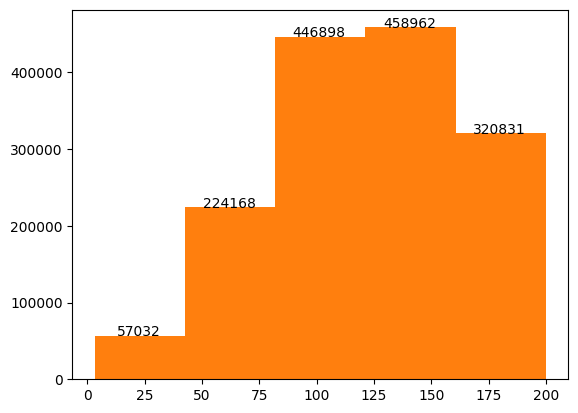

In [ ]:
data_filtrado = data[data["ocu"] < 200]
frec = data_filtrado["ocu"]

plt.hist(frec, bins=5)
frecuencias = plt.hist(frec, bins=5)[0]

for i, frecuencia in enumerate(frecuencias):
    plt.text(x=(plt.hist(frec, bins=5)[1][i] + plt.hist(frec, bins=5)[1][i+1]) / 2 - 0.5,
             y=frecuencia + 0.1,
             s=str(int(frecuencia)),
             size=10,
             ha='center')

plt.show()
